# Imports

In [ ]:
import zipfile, os
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import numpy as np
from tqdm import tqdm

from torchvision import transforms
import torchvision.transforms.functional as TF

import random

# Utils

In [ ]:
def parse_plate_from_filename(filename, provinces, alphabets, ads):
    name = os.path.splitext(os.path.basename(filename))[0]
    parts = name.split('-')
    if len(parts) < 6:
        raise ValueError(f"File format not valud: {filename}")

    indices = list(map(int, parts[4].split('_')))
    if len(indices) != 7:
        raise ValueError(f"Wrong indeces number in {filename}")

    try:
        plate = (
            provinces[indices[0]] +
            alphabets[indices[1]] +
            ''.join([ads[i] for i in indices[2:]])
        )
    except IndexError:
        raise ValueError(f"Index out of range in {filename}")

    return plate

In [ ]:
# Funzione per unire batch con label di lunghezza variabile
def collate_fn(batch):
    images, labels = zip(*batch)
    image_batch = torch.stack(images)
    label_lens = torch.tensor([len(label) for label in labels])
    labels_concat = torch.cat(labels)
    return image_batch, labels_concat, label_lens

In [ ]:
def greedy_decode(output, idx_to_char):
    output = output.permute(1, 0, 2)  # [B, T, C]
    decoded = []

    for probs in output:
        pred = torch.argmax(probs, dim=1).tolist()  # [T]
        prev = -1
        seq = []
        for p in pred:
            if p != prev and p != 0:
                seq.append(idx_to_char[p])
            prev = p
        decoded.append("".join(seq))

    return decoded


def compute_accuracy(preds, targets):
  correct_chars = total_chars = correct_plates = 0
  for p, t in zip(preds, targets):
      total_chars += max(len(p), len(t))
      correct_chars += sum(a == b for a, b in zip(p, t))
      if p == t:
          correct_plates += 1
  cer = correct_chars / total_chars
  plate_acc = correct_plates / len(targets)
  return cer, plate_acc

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def evaluate_on_loader(model, dataloader, idx_to_char, device):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)  # [T, B, C]
            preds = greedy_decode(outputs, idx_to_char)

            for pred, true in zip(preds, labels):
                all_preds.append(pred)
                all_targets.append(true)
                total += 1
                if pred == true:
                    correct += 1

    acc = correct / total * 100
    return all_preds, all_targets

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/Dataset_CV/RECOGNITION/CCPD2019_recognition.zip"

extract_dir = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Vocabulary
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫",
             "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N',
             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', 'O']

vocab = sorted(set(provinces + alphabets + ads))
idx_to_char = ['-'] + sorted(set(provinces + alphabets + ads))
char_to_idx = {char: idx for idx, char in enumerate(idx_to_char)}  # ora 0 = blank
num_classes = len(idx_to_char)

In [ ]:
class CCPDCRNNDatasetFromName(Dataset):
    def __init__(self, image_dir, transform, char_to_idx):
        self.image_dir = image_dir
        self.transform = transform
        self.char_to_idx = char_to_idx
        self.image_paths = [os.path.join(image_dir, f)
                            for f in sorted(os.listdir(image_dir))
                            if f.lower().endswith(".jpg")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_str = parse_plate_from_filename(img_path, provinces, alphabets, ads)
        label = torch.tensor([self.char_to_idx[c] for c in label_str], dtype=torch.long)

        return image, label

In [ ]:
class CCPDTestDataset(Dataset):
    def __init__(self, image_dir, transform, provinces, alphabets, ads):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(".jpg")
        ])
        self.transform = transform
        self.provinces = provinces
        self.alphabets = alphabets
        self.ads = ads

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        label_str = parse_plate_from_filename(path, self.provinces, self.alphabets, self.ads)
        if self.transform:
            image = self.transform(image)
        return image, label_str

In [ ]:
#Tranformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


train_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.04),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.02, 0.02),
        scale=(0.95, 1.05),
        shear=7
    ),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.02), ratio=(0.3, 3.0), value='random')
])


In [ ]:
# Dataset
train_dataset = CCPDCRNNDatasetFromName(
    image_dir="/content/CCPD2019_recognition/images/train",
    transform=train_transform,
    char_to_idx=char_to_idx
)

val_dataset = CCPDCRNNDatasetFromName(
    image_dir="/content/CCPD2019_recognition/images/val",
    transform=transform,
    char_to_idx=char_to_idx
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

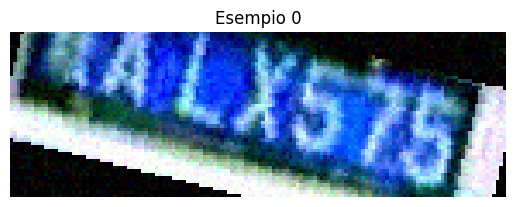

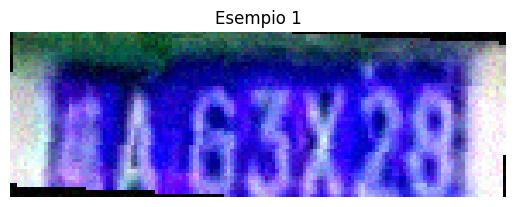

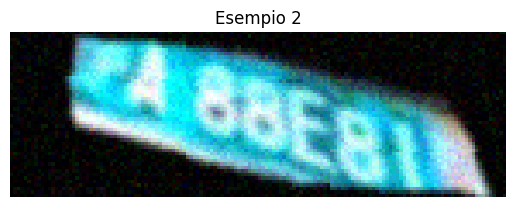

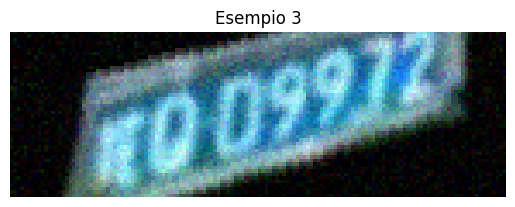

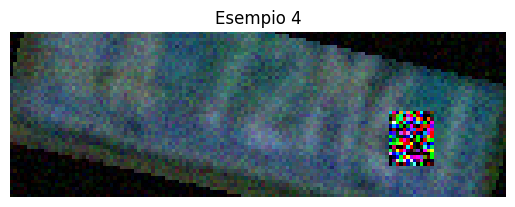

In [ ]:
for i in range(5):
    img, _ = train_dataset[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5
    plt.imshow(img.numpy())
    plt.title(f"Esempio {i}")
    plt.axis('off')
    plt.show()

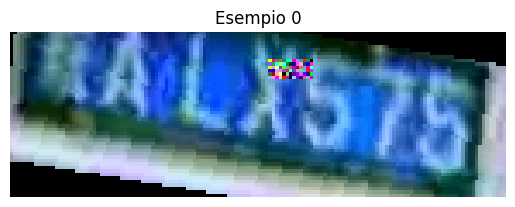

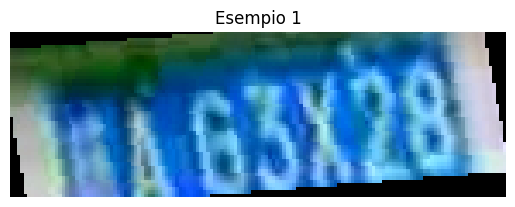

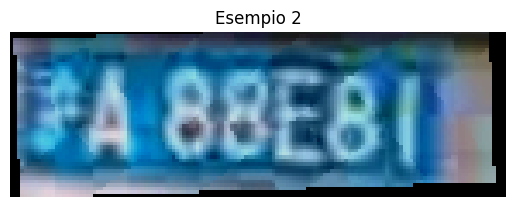

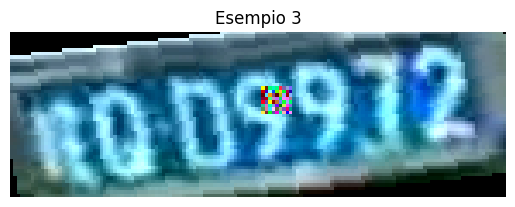

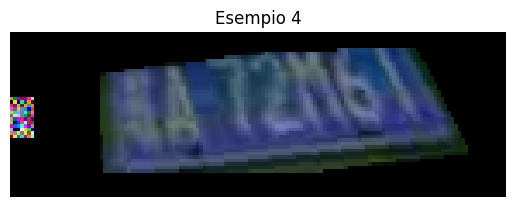

In [ ]:
for i in range(5):
    img, _ = train_dataset[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5
    plt.imshow(img.numpy())
    plt.title(f"Esempio {i}")
    plt.axis('off')
    plt.show()

# Network (CRNN)

In [ ]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()

        # INPUT: [B, 3, 48, 144]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # RGB input
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 64, 24, 72]

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 128, 12, 36]

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1)),  # [B, 256, 6, 37]

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1))   # [B, 512, 3, 38]
        )

        self.rnn = nn.GRU(input_size=512 * 3, hidden_size=128,
                  num_layers=1, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128 * 2, num_classes)


    def forward(self, x):
        conv = self.cnn(x)            # [B, 512, 3, 38]
        b, c, h, w = conv.size()
        conv = conv.permute(3, 0, 1, 2)   # [T=38, B, C, H=3]
        conv = conv.reshape(w, b, c * h) # [T=38, B, 512*3]

        rnn_out, _ = self.rnn(conv)      # [T, B, 512]
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)        # [T, B, num_classes]
        return F.log_softmax(output, dim=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = CRNN(img_height=48, num_classes=num_classes).to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)


cpu


# Train (with checkpoints)

In [ ]:
def train(model, train_loader, val_loader, epochs, device, optimizer, criterion, scheduler=None, seed=42):
    set_seed(seed)

    checkpoint_dir = "/content/drive/MyDrive/Computer_vision/crnn_weights_ccpd2019"
    os.makedirs(checkpoint_dir, exist_ok=True)
    last_ckpt_path = os.path.join(checkpoint_dir, "last_crnn.pth")
    best_ckpt_path = os.path.join(checkpoint_dir, "best_crnn.pth")

    best_val_loss = float('inf')
    start_epoch = 0

    # Checkpoint
    if os.path.exists(last_ckpt_path):
        checkpoint = torch.load(last_ckpt_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint trovato: riprendo da epoch {start_epoch}")

        if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    #train loop
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels, label_lengths in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / (pbar.n + 1),
                             lr=optimizer.param_groups[0]['lr'])

        val_loss = evaluate(model, val_loader)
        print(f"\nEpoch {epoch+1} - Val Loss: {val_loss:.4f}")

        if scheduler:
            scheduler.step(val_loss)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss
        }, last_ckpt_path)

        # Salva best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print("Best model saved!")


def evaluate(model, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            total_loss += loss.item()


            preds = greedy_decode(outputs, idx_to_char)

            targets = []
            start = 0
            for length in label_lengths:
                label_seq = labels[start:start+length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            print("Pred:", preds[:3])
            print("True:", targets[:3])
            break

    return total_loss / len(val_loader)


In [ ]:
train(model, train_loader, val_loader, 50, device, optimizer, criterion, scheduler=scheduler)

Epoch 1/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=2.95]


Pred: ['皖A8', '皖A8', '皖A8']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 1 - Val Loss: 0.0200
Best model saved!


Epoch 2/50: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s, lr=0.0001, train_loss=2.71]


Pred: ['皖A8', '皖A8', '皖A8']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 2 - Val Loss: 0.0196
Best model saved!


Epoch 3/50: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s, lr=0.0001, train_loss=2.66]


Pred: ['皖A906', '皖A706', '皖A906']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 3 - Val Loss: 0.0192
Best model saved!


Epoch 4/50: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s, lr=0.0001, train_loss=2.56]


Pred: ['皖A900', '皖A997', '皖A966']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 4 - Val Loss: 0.0174
Best model saved!


Epoch 5/50: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s, lr=0.0001, train_loss=1.33]


Pred: ['皖H47000', '皖A2H6X9', '皖N60166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 5 - Val Loss: 0.0030
Best model saved!


Epoch 6/50: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s, lr=0.0001, train_loss=0.38]


Pred: ['皖H47000', '苏A2H6X9', '皖N60166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 6 - Val Loss: 0.0016
Best model saved!


Epoch 7/50: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s, lr=0.0001, train_loss=0.257]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 7 - Val Loss: 0.0012
Best model saved!


Epoch 8/50: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s, lr=0.0001, train_loss=0.202]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 8 - Val Loss: 0.0010
Best model saved!


Epoch 9/50: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s, lr=0.0001, train_loss=0.172]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 9 - Val Loss: 0.0009
Best model saved!


Epoch 10/50: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s, lr=0.0001, train_loss=0.152]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 10 - Val Loss: 0.0008
Best model saved!


Epoch 11/50: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s, lr=0.0001, train_loss=0.141]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 11 - Val Loss: 0.0007
Best model saved!


Epoch 12/50: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s, lr=0.0001, train_loss=0.13]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 12 - Val Loss: 0.0008


Epoch 13/50: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s, lr=0.0001, train_loss=0.121]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 13 - Val Loss: 0.0007
Best model saved!


Epoch 14/50: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s, lr=0.0001, train_loss=0.111]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 14 - Val Loss: 0.0006
Best model saved!


Epoch 15/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=0.105]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 15 - Val Loss: 0.0005
Best model saved!


Epoch 16/50: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s, lr=0.0001, train_loss=0.103]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 16 - Val Loss: 0.0005
Best model saved!


Epoch 17/50: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s, lr=0.0001, train_loss=0.097]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 17 - Val Loss: 0.0005
Best model saved!


Epoch 18/50: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s, lr=0.0001, train_loss=0.0959]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 18 - Val Loss: 0.0005


Epoch 19/50: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s, lr=0.0001, train_loss=0.0885]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 19 - Val Loss: 0.0005


Epoch 20/50: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s, lr=0.0001, train_loss=0.0873]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 20 - Val Loss: 0.0006


Epoch 21/50: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s, lr=0.0001, train_loss=0.0834]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 21 - Val Loss: 0.0005


Epoch 22/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=0.0807]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 22 - Val Loss: 0.0005


Epoch 23/50: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s, lr=0.0001, train_loss=0.08]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 23 - Val Loss: 0.0004
Best model saved!


Epoch 24/50: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s, lr=0.0001, train_loss=0.0772]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 24 - Val Loss: 0.0004
Best model saved!


Epoch 25/50: 100%|██████████| 469/469 [02:23<00:00,  3.26it/s, lr=0.0001, train_loss=0.0722]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 25 - Val Loss: 0.0004
Best model saved!


Epoch 26/50: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s, lr=0.0001, train_loss=0.0734]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 26 - Val Loss: 0.0004
Best model saved!


Epoch 27/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=0.0707]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 27 - Val Loss: 0.0004


Epoch 28/50: 100%|██████████| 469/469 [02:30<00:00,  3.12it/s, lr=0.0001, train_loss=0.0692]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 28 - Val Loss: 0.0005


Epoch 29/50: 100%|██████████| 469/469 [02:25<00:00,  3.21it/s, lr=0.0001, train_loss=0.068]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 29 - Val Loss: 0.0003
Best model saved!


Epoch 30/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=0.0644]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 30 - Val Loss: 0.0003
Best model saved!


Epoch 31/50: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s, lr=0.0001, train_loss=0.0631]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 31 - Val Loss: 0.0004


Epoch 32/50: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s, lr=0.0001, train_loss=0.0628]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 32 - Val Loss: 0.0004


Epoch 33/50: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s, lr=0.0001, train_loss=0.0598]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 33 - Val Loss: 0.0004


Epoch 34/50: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s, lr=0.0001, train_loss=0.0618]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 34 - Val Loss: 0.0003
Best model saved!


Epoch 35/50: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s, lr=0.0001, train_loss=0.059]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 35 - Val Loss: 0.0004


Epoch 36/50: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s, lr=0.0001, train_loss=0.058]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 36 - Val Loss: 0.0003


Epoch 37/50: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, lr=0.0001, train_loss=0.0542]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 37 - Val Loss: 0.0004


Epoch 38/50: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s, lr=0.0001, train_loss=0.0573]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 38 - Val Loss: 0.0003
Best model saved!


Epoch 39/50: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, lr=0.0001, train_loss=0.0543]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 39 - Val Loss: 0.0002
Best model saved!


Epoch 40/50: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s, lr=0.0001, train_loss=0.0528]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 40 - Val Loss: 0.0002
Best model saved!


Epoch 41/50: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s, lr=0.0001, train_loss=0.0523]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 41 - Val Loss: 0.0002


Epoch 42/50:   4%|▍         | 19/469 [00:05<02:43,  2.76it/s, lr=0.0001, train_loss=0.0496]

In [ ]:
#restart
train(model, train_loader, val_loader, 50, device, optimizer, criterion, scheduler=scheduler)

Checkpoint trovato: riprendo da epoch 45


Epoch 46/50: 100%|██████████| 469/469 [02:23<00:00,  3.26it/s, lr=0.0001, train_loss=0.0496]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 46 - Val Loss: 0.0002


Epoch 47/50: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s, lr=8e-5, train_loss=0.0456]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 47 - Val Loss: 0.0003


Epoch 48/50: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s, lr=8e-5, train_loss=0.0442]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 48 - Val Loss: 0.0003


Epoch 49/50: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, lr=8e-5, train_loss=0.0432]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 49 - Val Loss: 0.0003


Epoch 50/50: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, lr=8e-5, train_loss=0.044]


Pred: ['皖H47000', '苏A2H6X9', '皖N6D166']
True: ['皖H47000', '苏A2H6X9', '皖N6D166']

Epoch 50 - Val Loss: 0.0002


# Test

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(img_height=48, num_classes=num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/Computer_vision/crnn_weights_ccpd2019/best_crnn.pth", map_location=device))
model.eval().to(device)


test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_base", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_base")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")

test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_blur", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_blur")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_challenge", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_challenge")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_db", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_db")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_fn", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_fn")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")

test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_rotate", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_rotate")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")

test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_tilt", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_tilt")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


test_dataset = CCPDTestDataset("/content/CCPD2019_recognition/images/testccpd_weather", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_weather")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


Evaluating: 100%|██████████| 289/289 [00:12<00:00, 23.79it/s]



Test ccpd_base
Character accuracy: 0.9993
Sequence accuracy:           0.9964


Evaluating: 100%|██████████| 137/137 [00:05<00:00, 24.05it/s]



Test ccpd_blur
Character accuracy: 0.8687
Sequence accuracy:           0.6097


Evaluating: 100%|██████████| 227/227 [00:09<00:00, 22.94it/s]



Test ccpd_challenge
Character accuracy: 0.9196
Sequence accuracy:           0.7213


Evaluating: 100%|██████████| 146/146 [00:05<00:00, 26.36it/s]



Test ccpd_db
Character accuracy: 0.9029
Sequence accuracy:           0.6627


Evaluating: 100%|██████████| 139/139 [00:05<00:00, 23.49it/s]



Test ccpd_fn
Character accuracy: 0.9572
Sequence accuracy:           0.8242


Evaluating: 100%|██████████| 174/174 [00:06<00:00, 25.77it/s]



Test ccpd_rotate
Character accuracy: 0.9802
Sequence accuracy:           0.8944


Evaluating: 100%|██████████| 136/136 [00:05<00:00, 24.05it/s]



Test ccpd_tilt
Character accuracy: 0.9560
Sequence accuracy:           0.7857


Evaluating: 100%|██████████| 267/267 [00:10<00:00, 25.38it/s]


Test ccpd_weather
Character accuracy: 0.9962
Sequence accuracy:           0.9808
